In [65]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np
from census import Census # This is new...

import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import os  

#import weightedcalcs as wc
#import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq

from bokeh.palettes import brewer, Spectral6
from bokeh.io import show, output_file, curdoc
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Panel, Tabs, GeoJSONDataSource, LinearColorMapper
from bokeh.models import ColorBar
from bokeh.layouts import column, gridplot, row
from bokeh.transform import factor_cmap
from bokeh.models import NumeralTickFormatter, Title, Label, Paragraph, Div, CustomJSHover, BoxAnnotation


In [66]:
country_list = pd.read_csv('./data/top_50_non_eu.csv', dtype={'CTY_CODE': str})

country_list.loc[len(country_list)] = ["EUROPEAN UNION", 0 , "0003"]

country_list["tariff"] = 10.0

country_list.loc[country_list["CTY_CODE"] == "5700", "tariff"] = 30.0

country_list.loc[country_list["CTY_CODE"] == "5820", "tariff"] = 30.0

country_list.loc[country_list["CTY_CODE"] == "1220", "tariff"] = 8.75

country_list.loc[country_list["CTY_CODE"] == "2010", "tariff"] = 4.5

country_list.loc[country_list["CTY_CODE"] == "0003", "tariff"] = 10.0

recipricol = pd.read_csv('./tariff-lists/reciprocal-tariffs-annex-I.csv', dtype={'CTY_CODE': str})

recipricol.rename(columns={"tariff_rate": "rtariff"}, inplace = True)

country_list = pd.merge(left = country_list, right = recipricol[["rtariff", "CTY_CODE"]], on = "CTY_CODE", how = "left")

country_list["rtariff"] = country_list["rtariff"].fillna(10.0)

country_list.loc[country_list["CTY_CODE"] == "5700", "rtariff"] = 34.0

country_list.loc[country_list["CTY_CODE"] == "5820", "rtariff"] = 34.0

In [67]:
country_list

,CTY_NAME,total_imports,CTY_CODE,tariff,rtariff
0,CHINA,5.728638e+12,5700,30.00,34.00
1,MEXICO,4.385957e+12,2010,4.50,4.50
2,CANADA,4.161438e+12,1220,8.75,8.75
3,JAPAN,1.701399e+12,5880,10.00,24.00
4,"KOREA, SOUTH",1.045098e+12,5800,10.00,26.00
5,VIETNAM,8.800542e+11,5520,10.00,46.00
6,TAIWAN,7.522322e+11,5830,10.00,32.00
7,INDIA,7.405954e+11,5330,10.00,27.00
8,UNITED KINGDOM,7.096412e+11,4120,10.00,10.00
9,SWITZERLAND,6.056859e+11,4419,10.00,32.00


In [68]:
new_list = pd.read_csv('./tariff-lists/clean-august-7-tariffs.csv')

new_list.rename({"country_name":"CTY_NAME"}, axis = 1, inplace = True)

country_list = pd.merge(country_list, new_list, on="CTY_NAME", how="left")

country_list["rtariff-aug"] = country_list["rtariff-aug"].fillna(country_list["rtariff"])

country_list.loc[country_list["CTY_NAME"] == "KOREA, SOUTH", "rtariff-aug"] = 15.0

country_list.loc[country_list["CTY_NAME"] == "EUROPEAN UNION", "rtariff-aug"] = 15.0

country_list.loc[country_list["CTY_NAME"] == "INDIA", "rtariff-aug"] = 50.0

In [69]:
country_list.tail()

,CTY_NAME,total_imports,CTY_CODE,tariff,rtariff,rtariff-aug
46,SRI LANKA,3.513664e+10,5420,10.0,44.0,20.0
47,ANGOLA,3.281314e+10,7620,10.0,32.0,15.0
48,EL SALVADOR,2.969949e+10,2110,10.0,10.0,10.0
49,EGYPT,2.710339e+10,7290,10.0,10.0,10.0
50,EUROPEAN UNION,0.000000e+00,0003,10.0,20.0,15.0


In [70]:
new_list.head(25)

,CTY_NAME,rtariff-aug
0,AFGHANISTAN,15.0
1,ALGERIA,30.0
2,ANGOLA,15.0
3,BANGLADESH,20.0
4,BOLIVIA,15.0
5,BOSNIA AND HERZEGOVINA,30.0
6,BOTSWANA,15.0
7,BRAZIL,10.0
8,BRUNEI,25.0
9,CAMBODIA,19.0


In [71]:
new_list = pd.read_csv('./tariff-lists/clean-august-7-tariffs.csv')


In [72]:
new_list.tail(50)

,country_name,rtariff-aug
18,FIJI,15.0
19,GHANA,15.0
20,GUYANA,15.0
21,ICELAND,15.0
22,INDIA,25.0
23,INDONESIA,19.0
24,IRAQ,35.0
25,ISRAEL,15.0
26,JAPAN,15.0
27,JORDAN,15.0


Step one is to read in the tariff lists, these come from the orginal Annex's published in the Federal Register

In [73]:
expemption_list = pd.read_csv('./tariff-lists/annex-II-exemptions.csv', dtype={'HTSUS': str})
# these are the annex II exemptions from the reciprical tariff list

expemption_list_phones = pd.read_csv('./tariff-lists/41225_exemptions.csv', dtype={'HTSUS': str})
# these are the phone exemptions

steel_list = pd.read_csv('./tariff-lists/steel-tariffs.csv', dtype={'HTSUS': str})
# these are the steel products subject to the new 232 tariffs. This is at 8 digit level.

alu_list = pd.read_csv('./tariff-lists/alu-tariffs.csv', dtype={'HTSUS': str})
# these are the aluminum products subject to the new 232 tariffs. This is at a mixed 8 and 10 digit level.

alu_8_list = alu_list[alu_list['HTSUS'].str.len() == 8]

auto_list = pd.read_csv('./tariff-lists/auto-tariffs.csv', dtype={'HTSUS': str})
# these are the aluminum products subject to the new 232 tariffs. This is at a mixed 8 and 10 digit level.

auto_6_list = auto_list[auto_list['HTSUS'].str.len() == 6]

auto_8_list = auto_list[auto_list['HTSUS'].str.len() == 8]

copper_list = pd.read_csv('./tariff-lists/copper-list.csv', dtype={'HTSUS': str})

brazil_nonaircraft_exemptions = pd.read_csv('./tariff-lists/brazil-non-airplane-exemptions.csv', dtype={'HTSUS': str})

brazil_aircraft_exemptions = pd.read_csv('./tariff-lists/brazil-airplane-exemptions.csv', dtype={'HTSUS': str})

nov_exemptions_list = pd.read_csv('./tariff-lists/annex-II-exemptions-nov14.csv', dtype={'HTSUS': str})

# country_list = pd.read_csv('./tariff-lists/reciprocal-tariffs-annex-I.csv',dtype={'CTY_CODE': str})

In [74]:
nov_exemptions_list

,HTSUS
0,02011005
1,02011010
2,02011050
3,02012002
4,02012004
...,...
1082,85423100
1083,85423200
1084,85423300
1085,85423900


In [75]:
def download_imports(cnty_code):

    my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"

    hs = 'HS10'

    my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"

    end_use = "hs?get=CTY_NAME,CON_VAL_YR,CAL_DUT_YR,I_COMMODITY,I_COMMODITY_SDESC"

    surl = "https://api.census.gov/data/timeseries/intltrade/imports/" + end_use 

    surl  = surl + my_key + "&time=" + "2024-12" + "&COMM_LVL=" + hs 

    url = surl + "&CTY_CODE=" + cnty_code

    r = requests.get(url) 
    
    print(r)
    
    df = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
    # Note that the first entry is the labels

    df.columns = r.json()[0]

    #######################################################################

    df.time = pd.to_datetime(df.time, format="%Y-%m")

    df["imports"] = df["CON_VAL_YR"].astype(float)

    df["duty"] = df["CAL_DUT_YR"].astype(float)

    df["share"] = df["imports"] / df["imports"].sum()
            
    df[hs] = df["I_COMMODITY"].astype(str)

    df["HS8"] = df["HS10"].str[0:8]

    df["HS6"] = df["HS10"].str[0:6]

    return df

In [76]:
# for index, row in country_list.iterrows():

#     foo = download_imports(row['CTY_CODE'])

#     outfile = "./data/2024-hs10-imports" + row['CTY_CODE'] + ".parquet"

#     pq.write_table(pa.Table.from_pandas(foo), outfile)

In [77]:
def tariff_imports(df, cnty_code, tariff, date):

    #######################################################################
    # this then filters so products are only those that are subject to the new tariffs
    # the reciprocal exemptions, steel, aluminum and auto tariffs.

    df["tariff"] = 0.0

    if date >= pd.to_datetime("2025-02-04"):
            
            df["tariff"] = 0.0

            df.loc[df["CTY_CODE"] == "5700", "tariff"] = 20.0

            df.loc[df["CTY_CODE"] == "5820", "tariff"] = 20.0

    if date >= pd.to_datetime("2025-03-06"):

        df["tariff"] = 0.0

        df.loc[df["CTY_CODE"] == "5700", "tariff"] = 20.0

        df.loc[df["CTY_CODE"] == "5820", "tariff"] = 20.0

        df.loc[df["CTY_CODE"] == "1220", "tariff"] = 8.75

        df.loc[df["CTY_CODE"] == "2010", "tariff"] = 4.5

    if date >= pd.to_datetime("2025-04-05"):

        df["tariff"] = tariff

        df.loc[df["CTY_CODE"] == "5700", "tariff"] = tariff + 20.0

        df.loc[df["CTY_CODE"] == "5820", "tariff"] = tariff + 20.0

        df.loc[df["CTY_CODE"] == "1220", "tariff"] = 8.75

        df.loc[df["CTY_CODE"] == "2010", "tariff"] = 4.5

    if date >= pd.to_datetime("2025-04-08"):

        df["tariff"] = tariff

        df.loc[df["CTY_CODE"] == "5700", "tariff"] = 84.0 + 20.0

        df.loc[df["CTY_CODE"] == "5820", "tariff"] = 84.0 + 20.0

        df.loc[df["CTY_CODE"] == "1220", "tariff"] = 8.75

        df.loc[df["CTY_CODE"] == "2010", "tariff"] = 4.5

    if date > pd.to_datetime("2025-04-09"):

        df["tariff"] = 10.0

        df.loc[df["CTY_CODE"] == "5700", "tariff"] = 125.0

        df.loc[df["CTY_CODE"] == "5820", "tariff"] = 125.0

        df.loc[df["CTY_CODE"] == "1220", "tariff"] = 8.75

        df.loc[df["CTY_CODE"] == "2010", "tariff"] = 4.5


    if date >= pd.to_datetime("2025-05-12"):

        df["tariff"] = 10.0

        df.loc[df["CTY_CODE"] == "1220", "tariff"] = 8.75

        df.loc[df["CTY_CODE"] == "2010", "tariff"] = 4.5

        df.loc[df["CTY_CODE"] == "5700", "tariff"] = 30.0

        df.loc[df["CTY_CODE"] == "5820", "tariff"] = 30.0

    if date >= pd.to_datetime("2025-08-07"):
        # these are the letter tariffs 
        # I think I have most of them

        df["tariff"] = tariff

        df.loc[df["CTY_CODE"] == "1220", "tariff"] = ( 8.75 / 25.0 ) * 35.0

        # df.loc[df["CTY_CODE"] == "2010", "tariff"] = ( 4.5 / 25.0 ) * 30.0

        # df.loc[df["CTY_CODE"] == "5700", "tariff"] = 30.0 # 30 percent on China

        # df.loc[df["CTY_CODE"] == "5820", "tariff"] = 30.0 # 30 percent on Hong Kong

        # df.loc[df["CTY_CODE"] == "0003", "tariff"] = 15.0 #30.0 # 10 percent on EU
        # #updated EU deal

        # df.loc[df["CTY_CODE"] == "5880", "tariff"] = 15.0
        # # old 25.0 # 25 percent on Japan
        # # awaiting fact sheet

        # df.loc[df["CTY_CODE"] == "5800", "tariff"] = 15.0 #Korea got a deal
        # #25.0 # 25 percent on Korea

        # df.loc[df["CTY_CODE"] == "7910", "tariff"] = 30.0 # 30 percent on South Africa

        # df.loc[df["CTY_CODE"] == "5570", "tariff"] = 25.0 # 30 percent on Malaysia

        # df.loc[df["CTY_CODE"] == "5600", "tariff"] = 19.0 
        # # old 32 percent on Indonesia
        # ## https://www.whitehouse.gov/fact-sheets/2025/07/fact-sheet-the-united-states-and-indonesia-reach-historic-trade-deal/

        # df.loc[df["CTY_CODE"] == "5380", "tariff"] = 35.0 # 30 percent on Bangladesh
        
        # df.loc[df["CTY_CODE"] == "5550", "tariff"] = 36.0 # 30 percent on Cambodia

        # df.loc[df["CTY_CODE"] == "5490", "tariff"] = 30.0 # 30 percent on Thailand

        df.loc[df["CTY_CODE"] == "3510", "tariff"] = 50.0 # +40 percent on Brazil

        # df.loc[df["CTY_CODE"] == "5520", "tariff"] = 20.0 # 30 percent on Vietnam

        # df.loc[df["CTY_CODE"] == "5650", "tariff"] = 20.0 # 30 percent on Philippines

    if pd.to_datetime("2025-11-01") <= date:

        df.loc[df["CTY_CODE"] == "5700", "tariff"] = tariff - 10.0 # new deal cut with China

        df.loc[df["CTY_CODE"] == "1220", "tariff"] = ( 8.75 / 25.0 ) * 45.0

    if pd.to_datetime("2025-11-14") <= date:

        df.loc[df["CTY_CODE"] == "4419", "tariff"] = 15.0 #swiss deal 

#####################################################################################################
# these are all the exemptions

    exemption = df["HS10"].isin(expemption_list["HTSUS"].tolist()) 

    df.loc[exemption, "tariff"]  = 0.0

    ####################################################
    # this is the phone exemption list. This is a 10 digit list.

    exemption_phones = df["HS10"].isin(expemption_list_phones["HTSUS"].tolist()) 

    if date >= pd.to_datetime("2025-04-11"):


        if cnty_code == "5700": # if china then still Fentanyl 20 percent on the phones

            df.loc[exemption_phones, "tariff"] = 20.0

        else:

            df.loc[exemption_phones, "tariff"] = 0.0

    ####################################################

    steel = df["HS8"].isin(steel_list["HTSUS"].tolist())

    if date >= pd.to_datetime("2025-03-12"):

        df.loc[steel, "tariff"]  = 25.0 

    if date >= pd.to_datetime("2025-06-03"):

        if cnty_code == "4120": # if the UK, then exempted from the increase

            df.loc[steel, "tariff"]  = 25.0 

        else:

            df.loc[steel, "tariff"]  = 50.0 


    ####################################################

    alu = df["HS10"].isin(alu_list["HTSUS"].tolist()) | df["HS8"].isin(alu_8_list["HTSUS"].tolist())

    if date >= pd.to_datetime("2025-03-12"):

        df.loc[alu, "tariff"]  = 25.0 

    if date >= pd.to_datetime("2025-06-03"):

        if cnty_code == "4120": # if the UK, then exempted from the increase
       
            df.loc[alu, "tariff"]  = 25.0 

        else:

            df.loc[alu, "tariff"]  = 50.0
        
    ####################################################

    auto = df["HS8"].isin(auto_8_list["HTSUS"].tolist()) | df["HS10"].isin(auto_list["HTSUS"].tolist()) | df["HS6"].isin(auto_6_list["HTSUS"].tolist())

    if date >= pd.to_datetime("2025-04-03"): 

        if cnty_code != "1220" and cnty_code != "2010": # if canada or mexico, then assumption is no tariff

            df.loc[auto, "tariff"]  = 25.0

    if date >= pd.to_datetime("2025-08-07"): 

        if cnty_code == "1220": # if canada or mexico, then assumption is no tariff

            df.loc[auto, "tariff"]  = 0.0

        elif cnty_code == "2010":

            df.loc[auto, "tariff"]  = 0.0

        elif cnty_code == "5880":
            # Japan gets an auto deal

            df.loc[auto, "tariff"]  = 15.0

        elif cnty_code == "0003":
        #EU gets and auto deal

            df.loc[auto, "tariff"]  = 15.0

        elif cnty_code == "5800":
        #Korea gets an auto deal

            df.loc[auto, "tariff"]  = 15.0

        else:
            df.loc[auto, "tariff"]  = 25.0

    ####################################################
            
    copper = df["HS8"].isin(copper_list["HTSUS"].tolist())

    if date >= pd.to_datetime("2025-08-07"): 

        df.loc[copper, "tariff"]  = 50.0

    ####################################################

    brazil_one = df["HS8"].isin(brazil_nonaircraft_exemptions["HTSUS"].tolist())
    
    brazil_two = df["HS8"].isin(brazil_aircraft_exemptions["HTSUS"].tolist())

    if date >= pd.to_datetime("2025-08-07"): 

        if cnty_code == "3510": # Brazil

            df.loc[brazil_one, "tariff"]  = 0.0

            df.loc[brazil_two, "tariff"]  = 0.0

    if date >= pd.to_datetime("2025-11-01"):

        if cnty_code == "5700": 

            df.loc[exemption_phones, "tariff"] = 20.0 - 10.0 # take 10 percent off the phones

    if date >= pd.to_datetime("2025-11-14"):

        nov_exemption = df["HS8"].isin(nov_exemptions_list["HTSUS"].tolist()) 

        df.loc[nov_exemption, "tariff"]  = 0.0
        


    return df

In [78]:
df = pd.DataFrame()

tariffs_by_date = pd.DataFrame(columns=['country_name',"effective tariff", "total imports", "date"])

date_strings = ["2025-02-04", "2025-03-06", "2025-03-12", "2025-04-03", "2025-04-05",
                "2025-04-08","2025-04-09","2025-04-11","2025-05-12","2025-06-03", "2025-08-07", "2025-11-01", "2025-11-14"]


for date_str in date_strings:

    date = pd.to_datetime(date_str)
    
    for index, row in country_list.iterrows():

        infile = "./data/2024-hs10-imports" + row['CTY_CODE'] + ".parquet"

        df = pq.read_table(infile).to_pandas()

        if date < pd.to_datetime("2025-08-07"): 

            foo = tariff_imports(df, row['CTY_CODE'], row["rtariff"], date)

        else:
            foo = tariff_imports(df, row['CTY_CODE'], row["rtariff-aug"], date)

    
        tariffs_by_date = tariffs_by_date.append({
            'country_name': foo['CTY_NAME'].iloc[0],
            'effective tariff': (foo['tariff'] * foo['share']).sum(),
            "total imports": foo['imports'].sum(),
            "2024 tariff": 100*(foo['duty'].sum() / foo['imports'].sum()),
            'date': date}, ignore_index=True)

In [79]:
tariffs_by_date.set_index("date", inplace = True)

In [80]:
tariffs_by_date.tail()

,country_name,effective tariff,total imports,2024 tariff
date,,,,
2025-11-14,SRI LANKA,18.881510,3.118528e+09,10.121829
2025-11-14,ANGOLA,2.625496,1.662168e+09,0.064706
2025-11-14,EL SALVADOR,9.834150,2.301947e+09,0.920599
2025-11-14,EGYPT,9.365275,2.559338e+09,1.820751
2025-11-14,EUROPEAN UNION,11.129221,5.974732e+11,1.229078


In [81]:

tariffs_by_date.to_csv("country-by-time.csv")

In [82]:
tariffs_by_date[tariffs_by_date["country_name"] == "SWITZERLAND"]

,country_name,effective tariff,total imports,2024 tariff
date,,,,
2025-02-04,SWITZERLAND,0.000000,6.091946e+10,0.596261
2025-03-06,SWITZERLAND,0.000000,6.091946e+10,0.596261
2025-03-12,SWITZERLAND,0.287789,6.091946e+10,0.596261
2025-04-03,SWITZERLAND,0.446413,6.091946e+10,0.596261
2025-04-05,SWITZERLAND,31.630838,6.091946e+10,0.596261
2025-04-08,SWITZERLAND,31.630838,6.091946e+10,0.596261
2025-04-09,SWITZERLAND,31.630838,6.091946e+10,0.596261
2025-04-11,SWITZERLAND,10.148970,6.091946e+10,0.596261
2025-05-12,SWITZERLAND,10.148970,6.091946e+10,0.596261


In [83]:
weighted_avg_tariff = (
    tariffs_by_date
    .groupby('date')
    .apply(lambda x: (x['effective tariff'] * x['total imports']).sum() / x['total imports'].sum() + 2.3)
    .reset_index(name='import_weighted_avg_tariff')
)

In [84]:


new_row = {
    'import_weighted_avg_tariff': 2.3,
    'date': pd.to_datetime('2025-01-01'),
}

weighted_avg_tariff = weighted_avg_tariff.append(new_row, ignore_index=True)

weighted_avg_tariff = weighted_avg_tariff.sort_values('date')

# new_row = {
# #     'import_weighted_avg_tariff':  weighted_avg_tariff.import_weighted_avg_tariff.iloc[-1],
# #     'date': pd.to_datetime('2025-06-25'),
# # }

# weighted_avg_tariff = weighted_avg_tariff.append(new_row, ignore_index=True)



In [85]:
weighted_avg_tariff

,date,import_weighted_avg_tariff
13,2025-01-01,2.300000
0,2025-02-04,4.981421
1,2025-03-06,6.548999
2,2025-03-12,7.230319
3,2025-04-03,8.948553
4,2025-04-05,24.374112
5,2025-04-08,30.221731
6,2025-04-09,30.221731
7,2025-04-11,22.152562
8,2025-05-12,13.831184


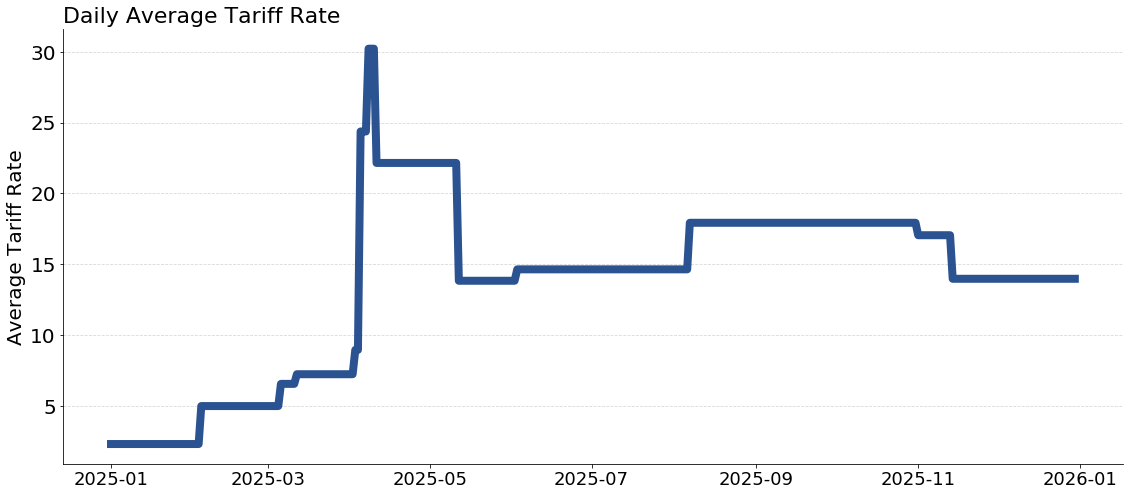

In [86]:
# 1. Set date as index if not already
weighted_avg_tariff = weighted_avg_tariff.set_index('date')

# 2. Create a regular date range (e.g., daily)
full_range = pd.date_range(weighted_avg_tariff.index.min(), '2025-12-30', freq='D')

# 3. Reindex and forward-fill missing values
weighted_avg_tariff_filled = weighted_avg_tariff.reindex(full_range).ffill()

# 4. Reset index for plotting
weighted_avg_tariff_filled = weighted_avg_tariff_filled.reset_index().rename(columns={'index': 'date'})

# 5. Plot as usual
fig, ax = plt.subplots(figsize = (19,8))

mike_blue = tuple(np.array([20, 64, 134]) / 255)

ax.plot(weighted_avg_tariff_filled['date'], weighted_avg_tariff_filled['import_weighted_avg_tariff'],
        alpha=0.90, color=mike_blue, linewidth=8, linestyle="-")



# ax.plot(weighted_avg_tariff.date, weighted_avg_tariff.import_weighted_avg_tariff, alpha = 0.90, color = mike_blue, linewidth = 8, linestyle= "-")

# ax.plot(merged_df.time.tail(2), merged_df.tariff.tail(2), alpha = 0.90, color = "darkred", linewidth = 8, linestyle= "-")

ax.set_ylabel('Average Tariff Rate', fontsize = 20)

ax.set_title("Daily Average Tariff Rate", fontsize = 22, loc= "left" )

# ax.set_xlim(dt.datetime(1928,1,31),dt.datetime(2028,1,1))

# ax.set_ylim(0,30)

ax.yaxis.grid(alpha= 0.5, linestyle= "--")

ax.tick_params(axis='x', labelsize=18)  # Change font size of x-axis tick labels
ax.tick_params(axis='y', labelsize=20)  # Change font size of y-axis tick labels

ax.spines["right"].set_visible(False)

ax.spines["top"].set_visible(False)


In [87]:
weighted_avg_tariff_filled.to_csv("daily-tariff-latest-data.csv")

In [88]:
weighted_avg_tariff_filled

,date,import_weighted_avg_tariff
0,2025-01-01,2.30000
1,2025-01-02,2.30000
2,2025-01-03,2.30000
3,2025-01-04,2.30000
4,2025-01-05,2.30000
...,...,...
359,2025-12-26,13.97059
360,2025-12-27,13.97059
361,2025-12-28,13.97059
362,2025-12-29,13.97059


In [89]:
weighted_avg_tariff_filled.tail()

,date,import_weighted_avg_tariff
359,2025-12-26,13.97059
360,2025-12-27,13.97059
361,2025-12-28,13.97059
362,2025-12-29,13.97059
363,2025-12-30,13.97059


In [90]:
weighted_avg_tariff_filled.import_weighted_avg_tariff.iloc[-1]

13.970590450211937

In [91]:
tariffs_by_date[tariffs_by_date["country_name"] == "CHINA"]

,country_name,effective tariff,total imports,2024 tariff
date,,,,
2025-02-04,CHINA,19.813157,4.294258e+11,10.865955
2025-03-06,CHINA,19.813157,4.294258e+11,10.865955
2025-03-12,CHINA,20.106812,4.294258e+11,10.865955
2025-04-03,CHINA,20.453844,4.294258e+11,10.865955
2025-04-05,CHINA,49.779538,4.294258e+11,10.865955
2025-04-08,CHINA,92.905559,4.294258e+11,10.865955
2025-04-09,CHINA,92.905559,4.294258e+11,10.865955
2025-04-11,CHINA,87.971326,4.294258e+11,10.865955
2025-05-12,CHINA,26.884080,4.294258e+11,10.865955
